In [1]:
from __future__ import print_function
import keras,sklearn
# suppress tensorflow compilation warnings
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow.compat.v1 as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
seed=0
np.random.seed(seed) # fix random seed
tf.compat.v1.set_random_seed(seed)
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from urllib.request import urlopen 
import requests
import io

Using TensorFlow backend.


In [2]:
all_cat_titles = ['airplane','monalisa','dragon','giraffe','axe','banana','eiffeltower','snail','windmill','snowman','schoolbus','smileyface','lollipop',]

img_rows, img_cols = 28, 28 

use_dataset_titles = ['X_use','Y_use']
ONLYFORFINALCOMPARATIVETEST_DATASETS_DONTYOUFUCKINGTOUCHTHESE = ['X_onlytest','Y_onlytest']
#DONT YOU DARE TOUCH THE ONLYTEST FILES.
#IF YOU ARE TRAINING A NEURAL NETWORK, TRAIN, VALIDATE, AND TEST FROM THE 'USE' FILES.

#load data
url_main = 'https://physics.bu.edu/~warsh/ML_QD/'
datalib={}

#loading samples
response = requests.get(url_main + use_dataset_titles[0] +'.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content), allow_pickle=False)
data = data.reshape(data.shape[0], img_rows*img_cols)
datalib[use_dataset_titles[0]] = data

response = requests.get(url_main + use_dataset_titles[1] +'.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content), allow_pickle=False)
datalib[use_dataset_titles[1]] = data

num_classes = int(max(datalib['Y_use'])+1)
cat_titles = all_cat_titles[:num_classes]
print('loaded:',cat_titles)

loaded: ['airplane', 'monalisa', 'dragon', 'giraffe', 'axe', 'banana', 'eiffeltower', 'snail', 'windmill', 'snowman']


an example of a data point with label snowman


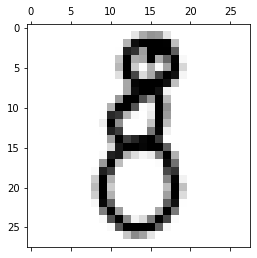

an example of a data point with label airplane


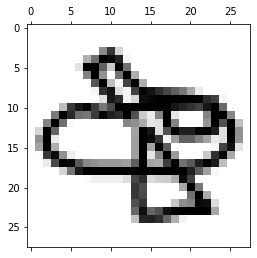

X_train shape: (863148, 28, 28, 1)
Y_train shape: (863148, 10)
X_valid shape: (215787, 28, 28, 1)
Y_valid shape: (215787, 10)
X_test shape: (269734, 28, 28, 1)
Y_test shape: (269734, 10)

863148 train samples
215787 validation samples
269734 test samples
1348669 total


In [4]:
Y_use = datalib['Y_use']
X_use = datalib['X_use']

#format, delegate, and scale data
ratio_use=1
#use small portion, randomized already:
numosamps = len(Y_use)*ratio_use #number of samples used for train, validation, and testsets
test_size=.2 #20% test
tr2valr=.8 #64% train, 16% validation
num_classes=int(max(Y_use)+1)

#scramble and split!
X_tr, X_test, Y_tr, Y_test = train_test_split(X_use, Y_use, test_size=test_size, train_size=1.0-test_size)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_tr,Y_tr,train_size=tr2valr,test_size=1-tr2valr)

#how much we usin'
X_train = X_train[0:int(numosamps*(1.0-test_size)*tr2valr)]
Y_train = Y_train[0:int(numosamps*(1.0-test_size)*tr2valr)]
X_valid = X_valid[0:int(numosamps*(1.0-test_size)*(1.0-tr2valr))]
Y_valid = Y_valid[0:int(numosamps*(1.0-test_size)*(1.0-tr2valr))]
X_test = X_test[0:int(numosamps*test_size)]
Y_test = Y_test[0:int(numosamps*test_size)]

#reshape into 2D
X_train = X_train.reshape(X_train.shape[0],img_rows,img_cols)
X_valid = X_valid.reshape(X_valid.shape[0],img_rows,img_cols)
X_test = X_test.reshape(X_test.shape[0],img_rows,img_cols)

#yeah okay some floats
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

#scale onto the fun zer-O to O-ne inverval
X_train /= 255
X_valid /= 255
X_test /= 255

#display some stuff
for i in range(2):
    print('an example of a data point with label', cat_titles[int(Y_train[i])])
    plt.matshow(X_train[i,:],cmap='binary')
    plt.show()

# converting the actual numbers to the the one-hot vectors
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
Y_valid = keras.utils.to_categorical(Y_valid, num_classes)

#reshape data, depending on Keras backend, final data formatting
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    X_valid = X_valid.reshape(X_valid.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols,1)
    input_shape = (img_rows, img_cols, 1)

#more debugging shit
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_valid shape:', X_valid.shape)
print('Y_valid shape:', Y_valid.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_valid.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

print(X_train.shape[0]+X_valid.shape[0]+X_test.shape[0], 'total')

In [40]:
#CNN pulled straight from Prof's NBs

def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    # add 2D pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # add second convolutional layer with 20 filters
    model.add(Conv2D(20, (5, 5), activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.25))
    # add 2D pooling layer
    model.add(MaxPooling2D(pool_size=(4, 4)))
    
    
    # flatten data
    model.add(Flatten())
    # add a dense all-to-all relu layer
    model.add(Dense(20*4*4, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.25))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    #lil something special to show us our architecture traits
    model.summary()
    return model

In [55]:
modelname='pls'

# training parameters
batch_size = 64
epochs = 2

# create the deep conv net
model_CNN=create_CNN()

# train CNN
model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_valid, Y_valid))

#evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 20)          5020      
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 20)          0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 20)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 320)              

In [56]:
#save trained model, make sure you have your path set up for this before running, also figure out your filenames
#file saving stuff
filedir = 'C:/Users/Warsh/ML_Notebooks_edited/mlqdproj/'
fileext = 'models/'
saveset=True
modelName=modelname
if saveset==True:
    modpath = filedir+fileext+modelName
    savfil = modpath
    i=1
    yeet=False
    if os.path.exists(savfil+'.h5')==True:
        print(savfil+'.h5 already exists, please choose different name')
    else:
        model_CNN.save(savfil+'.h5')#the last trained model is called model_CNN
        yeet=True
        print("Saved model to disk: "+savfil+'.h5')

Saved model to disk: C:/Users/Warsh/ML_Notebooks_edited/mlqdproj/models/pls.h5


In [58]:
#loading trained models to evaluate on the same test sets and compare, make sure your paths are chill before running
#totally also make sure you scramble the test part of the X_use and Y_use before you compare otherwise thats just not chill bro.
#also dont you dare touch my special only touch datasets, we save those bad boys for when we compare our final trained models

#load from internet
url_main = 'https://physics.bu.edu/~warsh/ML_QD/'
modelfile = '500perkil_1epoch.h5'
response = requests.get(url_main + modelfile)
response.raise_for_status()
model_500perkil = load_model(io.BytesIO(response.content))

url_main = 'https://physics.bu.edu/~warsh/ML_QD/'
modelfile = '500perkil_2epoch.h5'
response = requests.get(url_main + modelfile)
response.raise_for_status()
model_500perkil2 = load_model(io.BytesIO(response.content))

#load from local drive
filedir = 'C:/Users/Warsh/ML_Notebooks_edited/mlqdproj/'
fileext = 'models/'
modelfile = 'pls.h5'
model_pls = load_model(filedir+fileext+modelfile)

#evaluate models - note: loaded test set must have same expected samples as the trained set
score500perkil = model_500perkil.evaluate(X_test, Y_test, verbose=1)
score500perkil2 = model_500perkil2.evaluate(X_test, Y_test, verbose=1)
scorepls = model_pls.evaluate(X_test, Y_test, verbose=1)

print('               500perkil 1ep  500perkil 2ep   pls')
print('    Test loss: %.8f'%score500perkil[0] + ' %.8f'%score500perkil[0] + ' %.8f'%scorepls[0])
print('Test accuracy: %.12f'%score500perkil2[1] + ' %.12f'%score500perkil2[1] + ' %.8f'%scorepls[1])

2697/2697 [==============================] - 1s 331us/step
               500perkil 1ep  500perkil 2ep   pls
    Test loss: 0.22396112 0.22396112 0.61132777
Test accuracy: 0.941787183285 0.941787183285 0.83611423
